In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('dados/banking.db')

query = """
SELECT
    *
FROM
    cdi_mensal
"""

cdi = pd.read_sql_query(query, conn)

conn.close()



In [2]:
cdi['cdi'] = cdi['cdi'].str.replace(',', '.', regex=False).astype(float)

cdi['delta_cdi'] = cdi['cdi'].shift(-1) - cdi['cdi']
cdi['delta_cdi_lag_1'] = cdi['delta_cdi'].shift(1)
cdi['delta_cdi_lag_2'] = cdi['delta_cdi'].shift(2)

cdi = cdi.dropna(how='any', subset=['delta_cdi', 'delta_cdi_lag_1', 'delta_cdi_lag_2'])


In [3]:
import statsmodels.api as sm

X = cdi[['delta_cdi_lag_1', 'delta_cdi_lag_2']]
y = cdi['delta_cdi']

reg = sm.OLS(y, sm.add_constant(X)).fit()
results_reg = reg
print(results_reg.summary())

cdi_estimado = cdi[['data', 'cdi', 'delta_cdi']]
cdi_estimado['delta_cdi_estimado'] = results_reg.predict()
cdi_estimado['residuo'] = cdi_estimado['delta_cdi'] - cdi_estimado['delta_cdi_estimado']

                            OLS Regression Results                            
Dep. Variable:              delta_cdi   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     49.30
Date:                Sat, 25 Oct 2025   Prob (F-statistic):           6.62e-18
Time:                        18:24:37   Log-Likelihood:                -69.243
No. Observations:                 189   AIC:                             144.5
Df Residuals:                     186   BIC:                             154.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0092      0.026     

/tmp/ipykernel_1104603/2392937685.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdi_estimado['delta_cdi_estimado'] = results_reg.predict()
/tmp/ipykernel_1104603/2392937685.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdi_estimado['residuo'] = cdi_estimado['delta_cdi'] - cdi_estimado['delta_cdi_estimado']


In [ ]:
# GARCH
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

cdi_diff = cdi['cdi'].diff().dropna()
cdi_diff_pct = cdi_diff * 100

modelo_garch = arch_model(
    cdi_diff_pct,
    mean='constant',
    vol='Garch',
    p=1, q=1,
    dist='normal'
)

resultados_garch = modelo_garch.fit(disp='off')
print(resultados_garch.summary())

volatilidade_cdi = resultados_garch.conditional_volatility

cdi_estimado = cdi_estimado.join(volatilidade_cdi, how='inner')

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    cdi   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -937.537
Distribution:                  Normal   AIC:                           1883.07
Method:            Maximum Likelihood   BIC:                           1896.02
                                        No. Observations:                  188
Date:                Sat, Oct 25 2025   Df Residuals:                      187
Time:                        18:25:04   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.6327      2.793      0.585      0.559 [ -3.841,  7.10

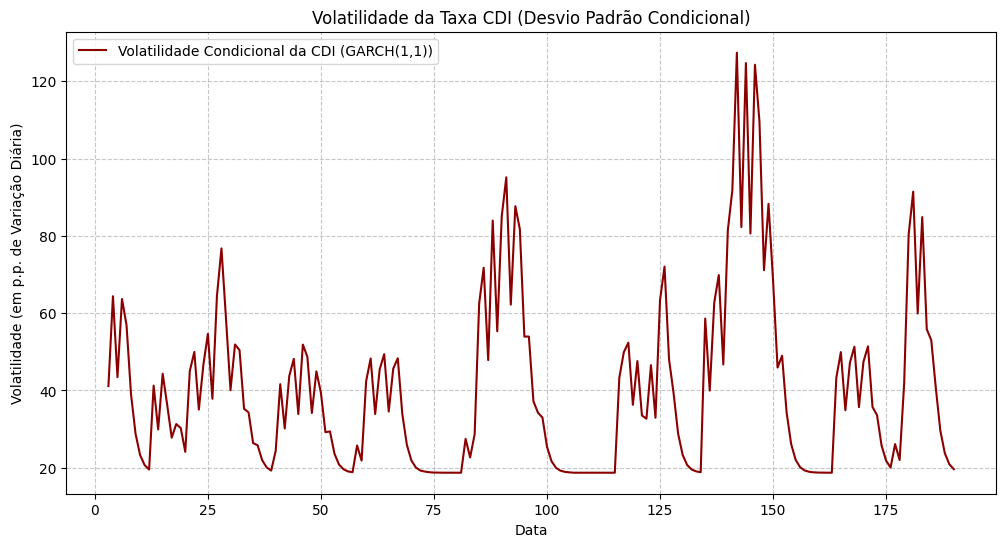

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(volatilidade_cdi, label='Volatilidade Condicional da CDI (GARCH(1,1))', color='darkred')
plt.title('Volatilidade da Taxa CDI (Desvio Padrão Condicional)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (em p.p. de Variação Diária)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///dados/banking.db')

cdi_estimado.to_sql(
    'cdi_estimado',
    engine,
    if_exists='replace',
    index=False,
    chunksize=1000
)


188